In [46]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install category_encoders

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preprocesamiento
El análisis exploratorio permitió ver que la mayoría de variables eran categóricas y carecían de valores nulos por imputar .

In [48]:
df = pd.read_csv('TelcoCustomerChurn.csv').drop(columns = ['customerID'])

In [49]:
df.shape

(7043, 20)

In [50]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


En el análisis bivariado se observó que las siguientes variables no discriminaban la variable objetivo:

1.   Genero (gender)
2.   Multilínea (MultipleLines)
3.   Servicio Movil (PhoneService)
4.   StreamingTV
5.   StreamingMovies

Se procede, por tanto, a removerlas del set de datos.

In [51]:
df.drop(columns = ['gender', 'MultipleLines', 'PhoneService', 'StreamingTV', 'StreamingMovies'], inplace = True)

Revisamos los tipos de datos para identificar inconsistencias. Ningún número debería estar como object.

In [52]:
df.dtypes

SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Se observa que TotalCharges está como object, siendo este un valor numérico continuo. Ello indica que probablemente haya algún valor no numérico en la data, lo cual se comprobó en 11 casos.

In [53]:
df.loc[(df.TotalCharges.str.contains(r'\s')==True), 'TotalCharges'].count()

11

Siendo pocos los registros con el valor incorrecto de TotalCharges, se procede a eliminarlos. Finalmente, se asigna a la variable el tipo de dato correcto.

In [54]:
df = df.loc[~(df.TotalCharges.str.contains(r'\s')==True)]
df.shape

(7032, 15)

In [55]:
df['TotalCharges'] = df['TotalCharges'] .astype('float64')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Se valida que ninguna columna tenga valores en blanco.

In [56]:
df.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Se valida la existencia de outliers en las columnas numéricas.

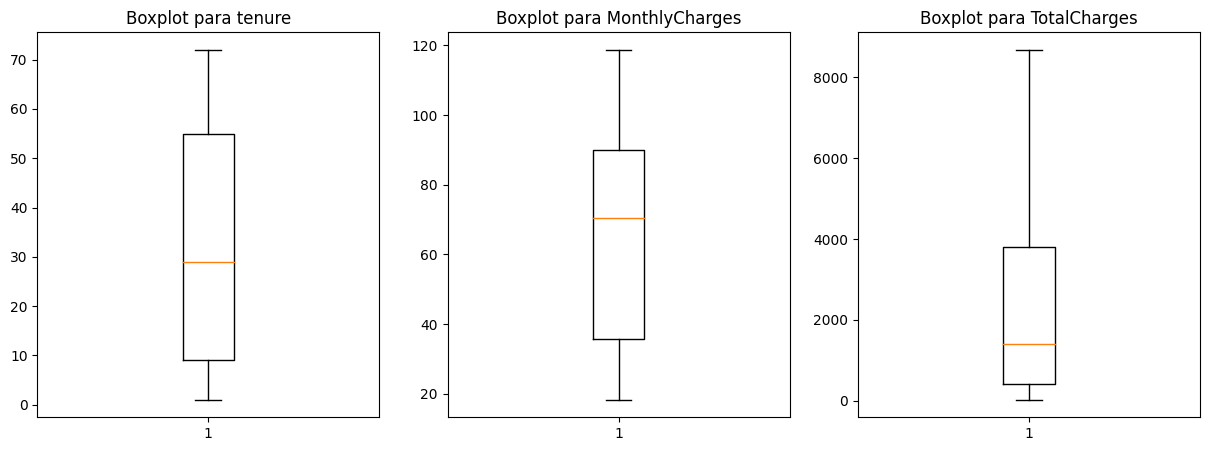

In [57]:
i = 1
plt.figure(figsize=(15,5))
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
  plt.subplot(1,3,i)
  plt.boxplot(df[col])
  plt.title(f'Boxplot para {col}')
  i += 1
plt.show()

In [58]:
df.select_dtypes('object').nunique()

Partner             2
Dependents          2
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
Contract            3
PaperlessBilling    2
PaymentMethod       4
Churn               2
dtype: int64

Se procesa el target (Churn) para volverlo numérico.

In [59]:
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

In [60]:
df.dtypes

SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

## Transformación
Para la selección de modelos, se evaluará el desempeño del modelo usando árboles de decisión y regresión logística. Ello debido a la característica de interpretabilidad requerida (no se evaluarán modelos de caja negra). Por las características de ambos algoritmos, cada uno requiere una transformación distinta del dataset. Por ello, se trabajará en dos copias del original.

In [131]:
df_lr = df.copy(deep=True)
df_dt = df.copy(deep=True)

### Transformación para Árbol de Decisión

In [132]:
df_dt.select_dtypes('object').nunique()

Partner             2
Dependents          2
InternetService     3
OnlineSecurity      3
OnlineBackup        3
DeviceProtection    3
TechSupport         3
Contract            3
PaperlessBilling    2
PaymentMethod       4
dtype: int64

En vista que los árboles se construyen con el algoritmo CART, las variables categóricas se pueden codificar como numéricas directamente. El algoritmo se basa en encontrar puntos de corte para minimizar el GINI, no toma en cuenta distancias o pesos.

In [133]:
# Variables binarias
df_dt['Partner'] = df_dt['Partner'].map({'Yes':1,'No':0})
df_dt['Dependents'] = df_dt['Dependents'].map({'Yes':1,'No':0})
df_dt['PaperlessBilling'] = df_dt['PaperlessBilling'].map({'Yes':1,'No':0})

# Variables ternarias
df_dt['InternetService'] = df_dt['InternetService'].map({'Fiber optic':2, 'DSL':1, 'No':0})
df_dt['OnlineSecurity'] = df_dt['OnlineSecurity'].map({'Yes':2, 'No':1, 'No internet service':0})
df_dt['OnlineBackup'] = df_dt['OnlineBackup'].map({'Yes':2, 'No':1, 'No internet service':0})
df_dt['DeviceProtection'] = df_dt['DeviceProtection'].map({'Yes':2, 'No':1, 'No internet service':0})
df_dt['TechSupport'] = df_dt['TechSupport'].map({'Yes':2, 'No':1, 'No internet service':0})
df_dt['Contract'] = df_dt['Contract'].map({'Month-to-month':2, 'Two year':1, 'One year':0})

# Variables cuaternarias
df_dt['PaymentMethod'] = df_dt['PaymentMethod'].map({'Electronic check':4, 'Mailed check':2, 'Bank transfer (automatic)':1, 'Credit card (automatic)':0})

In [134]:
df_dt.dtypes

SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [135]:
df_dt.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,1,1,2,1,1,2,1,4,29.85,29.85,0
1,0,0,0,34,1,2,1,2,1,0,0,2,56.95,1889.50,0
2,0,0,0,2,1,2,2,1,1,2,1,2,53.85,108.15,1
3,0,0,0,45,1,2,1,2,2,0,0,1,42.30,1840.75,0
4,0,0,0,2,2,1,1,1,1,2,1,4,70.70,151.65,1


### Transformación para Regresión Logística
Para la regresión logística, se empleará la codificación por "weight of evidence" (o WoEs), cuya forma logarítmica resulta conveniente para la función logística. Dado que este método de codificación requiere cierto conocimiento del target, se separa el dataset antes para evitar la fuga de información. Por tanto, toda la transformación se verá en la etapa de modelado.
Se transforma la variable SeniorCitizen a una forma categórica para que sea codificada usando WoE.

In [209]:
df_lr['SeniorCitizen'] = np.where(df_lr['SeniorCitizen']==1,'Yes','No')

## Modelamiento
Se procederá a entrenar los modelos, los cuales serán, en la medida de lo posible, modelos que sean posibles de interpretar. Primero, se separará un conjunto que no se usará hasta el final para validar resultados (test). Para la selección del modelo se empleará un esquema de validación cruzada de 10 grupos (10-fold cross-validation) con los datos restantes. La métrica que se usará para comparar los modelos será el área bajo la curva ROC. Dado que no se observó desbalance fuerte en los datos, se puede usar esta métrica como referencia esta métrica en lugar del área bajo la curva de precision-recall.


### Modelos Lineales - Regresión Logística

In [281]:
from sklearn.model_selection import train_test_split

X_lr = df_lr.drop(columns = ['Churn'])
y_lr = df_lr['Churn']

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size = 0.2, stratify = y_lr, random_state = 932)

In [282]:
from sklearn.preprocessing import MinMaxScaler
from category_encoders.woe import WOEEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])

preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[('mm', minmax_transformer , ['tenure','MonthlyCharges', 'TotalCharges'])])

pipeline = make_pipeline(WOEEncoder(), preprocessor, LogisticRegression(solver='liblinear'))
cv_lr = cross_val_score(pipeline, X_train_lr, y_train_lr, scoring = 'roc_auc', cv = 10)
print(f'Logistic Regression: {cv_lr.mean():.4} +/- {cv_lr.std():.4}')

Logistic Regression: 0.8425 +/- 0.02042


Dado que en el exploratorio se observó que cerca de un 55% de clientes tenían un contrato mensual, y este grupo tenía un churn particularmente alto, se procede a evaluar si performance mejoraría si se tienen modelos separados por segmentos. En este caso, se separa entre los que tienen renta mensual y los que no.

In [232]:
# Segmento con contrato mensual (55%)
X_lr_mes   = df_lr.loc[df_lr.Contract == 'Month-to-month'].drop(columns = ['Churn'])
y_lr_mes   = df_lr.loc[df_lr.Contract == 'Month-to-month', 'Churn']
X_train_lr_mes, X_test_lr_mes, y_train_lr_mes, y_test_lr_mes = train_test_split(X_lr_mes, y_lr_mes, test_size = 0.2, stratify = y_lr_mes, random_state = 932)

# Segmento con contrato anual o bianual
X_lr_nomes = df_lr.loc[df_lr.Contract != 'Month-to-month'].drop(columns = ['Churn'])
y_lr_nomes = df_lr.loc[df_lr.Contract != 'Month-to-month', 'Churn']
X_train_lr_nomes, X_test_lr_nomes, y_train_lr_nomes, y_test_lr_nomes = train_test_split(X_lr_nomes, y_lr_nomes, test_size = 0.2, stratify = y_lr_nomes, random_state = 932)

In [234]:
# Configuración del pipeline
pipeline_mes   = make_pipeline(WOEEncoder(), preprocessor, LogisticRegression(solver='liblinear'))
pipeline_nomes = make_pipeline(WOEEncoder(), preprocessor, LogisticRegression(solver='liblinear'))

# Validación cruzada
cv_lr_mes   = cross_val_score(pipeline_mes, X_train_lr_mes, y_train_lr_mes, scoring = 'roc_auc', cv = 10)
cv_lr_nomes = cross_val_score(pipeline_nomes, X_train_lr_nomes, y_train_lr_nomes, scoring = 'roc_auc', cv = 10)

# Resultados
print(f'Logistic Regression Mes: {cv_lr_mes.mean():.4} +/- {cv_lr_mes.std():.4}')
print(f'Logistic Regression NoMes: {cv_lr_nomes.mean():.4} +/- {cv_lr_nomes.std():.4}')

Logistic Regression Mes: 0.7481 +/- 0.02083
Logistic Regression NoMes: 0.7851 +/- 0.04287


En vista que el modelo segmentado performa peor, en caso el mejor modelo resulte ser una logística, se deberá trabajar con la población completa.

### Modelos de Árbol

Se comparará el comportamiento de un árbol de decisión, random forest y xgboost.

In [283]:
from sklearn.model_selection import train_test_split

X_tr = df_dt.drop(columns = ['Churn'])
y_tr = df_dt['Churn']

X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_tr, y_tr, test_size = 0.2, stratify = y_tr, random_state = 932)

In [284]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb

clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()
clf_xg = xgb.XGBClassifier()

cv_dt  = cross_val_score(clf_dt, X_train_tr, y_train_tr, scoring = 'roc_auc', cv = 10)
cv_rf  = cross_val_score(clf_rf, X_train_tr, y_train_tr, scoring = 'roc_auc', cv = 10)
cv_xg  = cross_val_score(clf_xg, X_train_tr, y_train_tr, scoring = 'roc_auc', cv = 10)

print(f'Decision Tree: {cv_dt.mean():.4} +/- {cv_dt.std():.4}')
print(f'Random Forest: {cv_rf.mean():.4} +/- {cv_rf.std():.4}')
print(f'XGBoost: {cv_xg.mean():.4} +/- {cv_xg.std():.4}')

Decision Tree: 0.6551 +/- 0.0187
Random Forest: 0.8202 +/- 0.02526
XGBoost: 0.8225 +/- 0.02351


En función de los resultados obtenidos, puede observarse que un algoritmo simple e interpretable como una regresion logística es suficiente para obtener buenos resultados, comparables con algoritmos de caja negra como el XGBoost (están en el mismo rango de AUC promedio). Si bien es cierto, optimizando hiperparámetros se puede mejorar la performance, no se espera tener un boost tan grande. En consecuencia, el modelo a implementar sería una regresión logística o un random forest.

### Optimización de hiperparámetros

### Regresión Logistica

In [287]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'logistic__C': [0.001, 0.1, 10, 100, 1000, 10000],
    'logistic__penalty':['l1','l2'],
    'logistic__class_weight':[None,'balanced']
}

pipeline = Pipeline(steps=[("encoder", WOEEncoder()), ('minmax',preprocessor), ("logistic", LogisticRegression(solver='liblinear'))])
grid_search_lr = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1, verbose = 2)
grid_search_lr.fit(X_train_lr, y_train_lr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('encoder', WOEEncoder()),
                                       ('minmax',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mm',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges'])])),
                                       ('logistic',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.001, 0.1, 10, 100, 1000, 10000],
                         'logistic__class_weight': [None, 'balanced'],
                         'logistic__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=2)

In [288]:
print(f'El mejor score ({grid_search_lr.best_score_:.4}) se obtuvo con la configuracion: {grid_search_lr.best_params_}')

El mejor score (0.8432) se obtuvo con la configuracion: {'logistic__C': 1000, 'logistic__class_weight': None, 'logistic__penalty': 'l1'}


### Random Forest

In [290]:
param_grid_rf = {
    'max_depth': [3,6,9],
    'max_features':[4,8,12],
    'n_estimators':[100,250,500]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid_rf, scoring = 'roc_auc', cv = 5, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train_tr, y_train_tr)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9], 'max_features': [4, 8, 12],
                         'n_estimators': [100, 250, 500]},
             scoring='roc_auc', verbose=2)

In [291]:
print(f'El mejor score ({grid_search_rf.best_score_:.4}) se obtuvo con la configuracion: {grid_search_rf.best_params_}')

El mejor score (0.8461) se obtuvo con la configuracion: {'max_depth': 6, 'max_features': 4, 'n_estimators': 100}


In [292]:
# Código obtenido de la documentación de sklearn
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

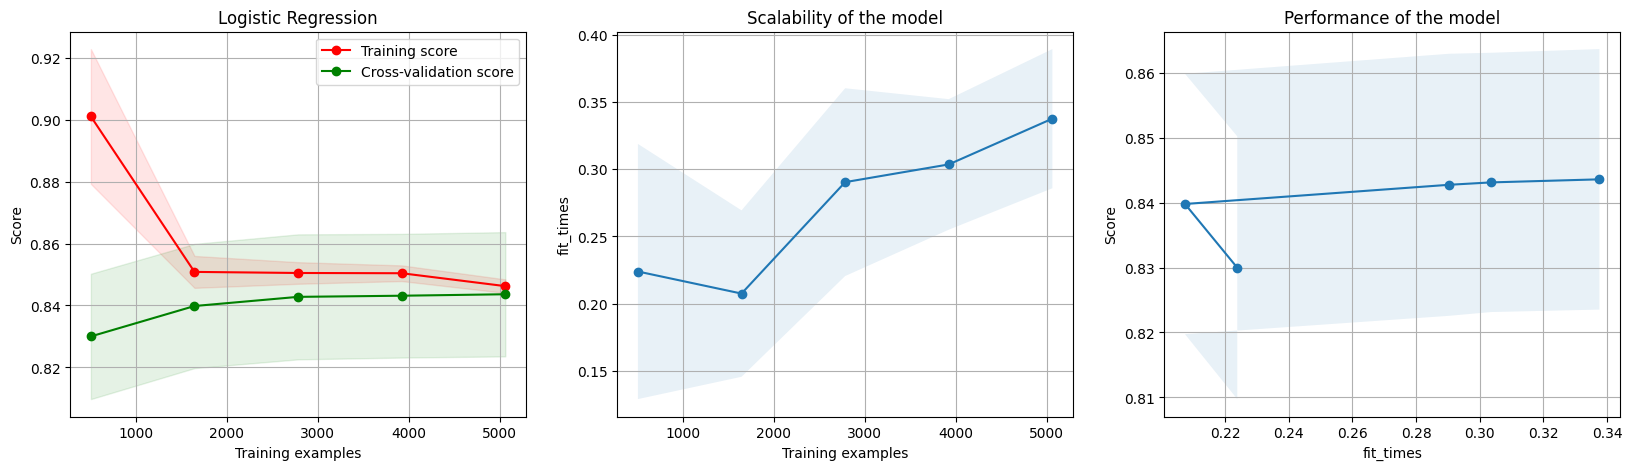

In [293]:
estimator = Pipeline(steps=[("encoder", WOEEncoder()), ('minmax',preprocessor), ("logistic", LogisticRegression(solver='liblinear', penalty='l1', C=1000, class_weight=None))])
plot_learning_curve(estimator, 'Logistic Regression', X_train_lr, y_train_lr, cv=10)
plt.show()

Como la curva de entrenamiento (roja) y validación (verde) están cerca una de la otra, no estamos ante un caso de overfit.

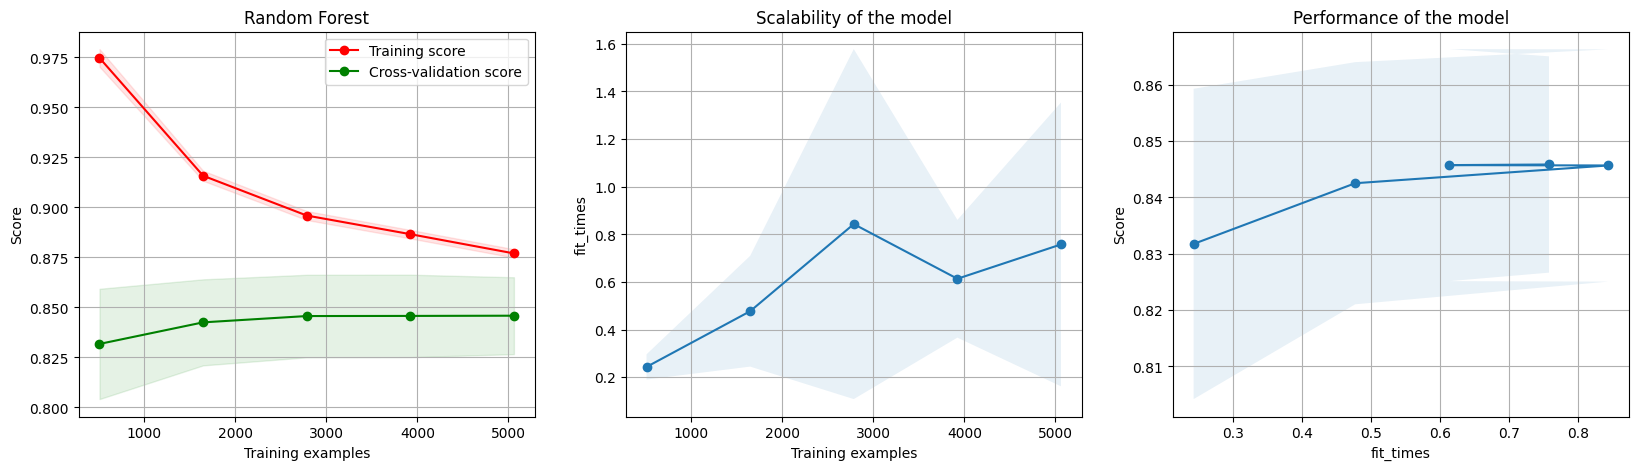

In [297]:
estimator_rf = RandomForestClassifier(max_depth = 6, max_features = 4, n_estimators = 100)
plot_learning_curve(estimator_rf, 'Random Forest', X_train_tr, y_train_tr, cv=10)
plt.show()

Puede observarse cierto grado de sobreajuste en la curva. Se incrementa la poda, disminuyendo el valor del parámetro max_depth.

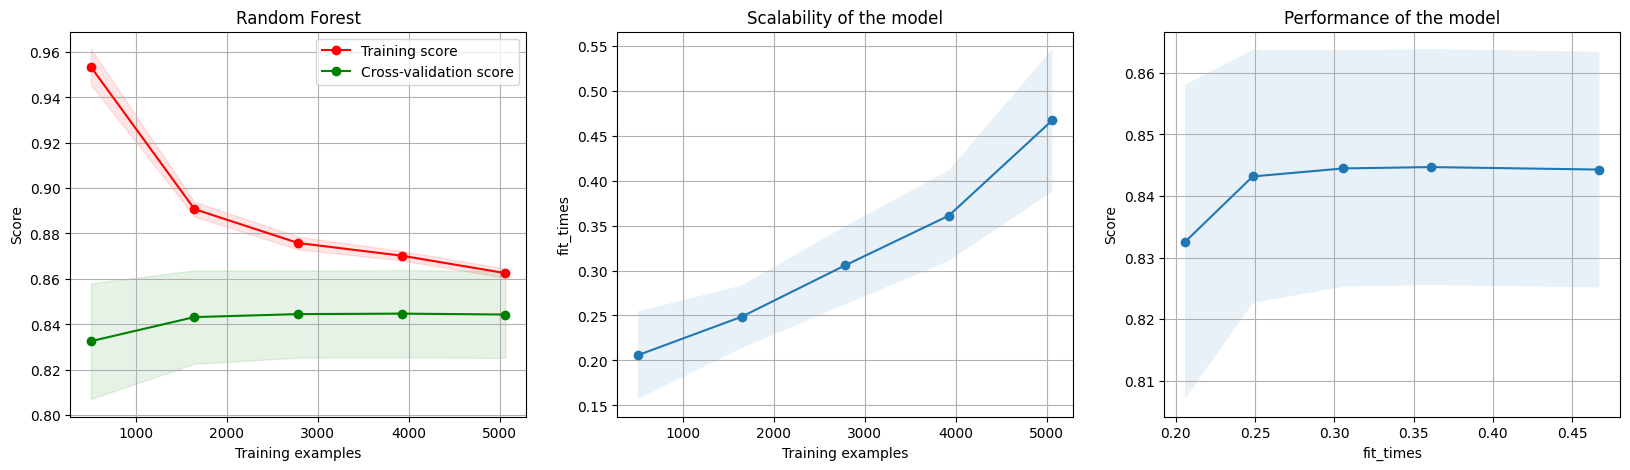

In [298]:
estimator_rf = RandomForestClassifier(max_depth = 5, max_features = 4, n_estimators = 100)
plot_learning_curve(estimator_rf, 'Random Forest', X_train_tr, y_train_tr, cv=10)
plt.show()

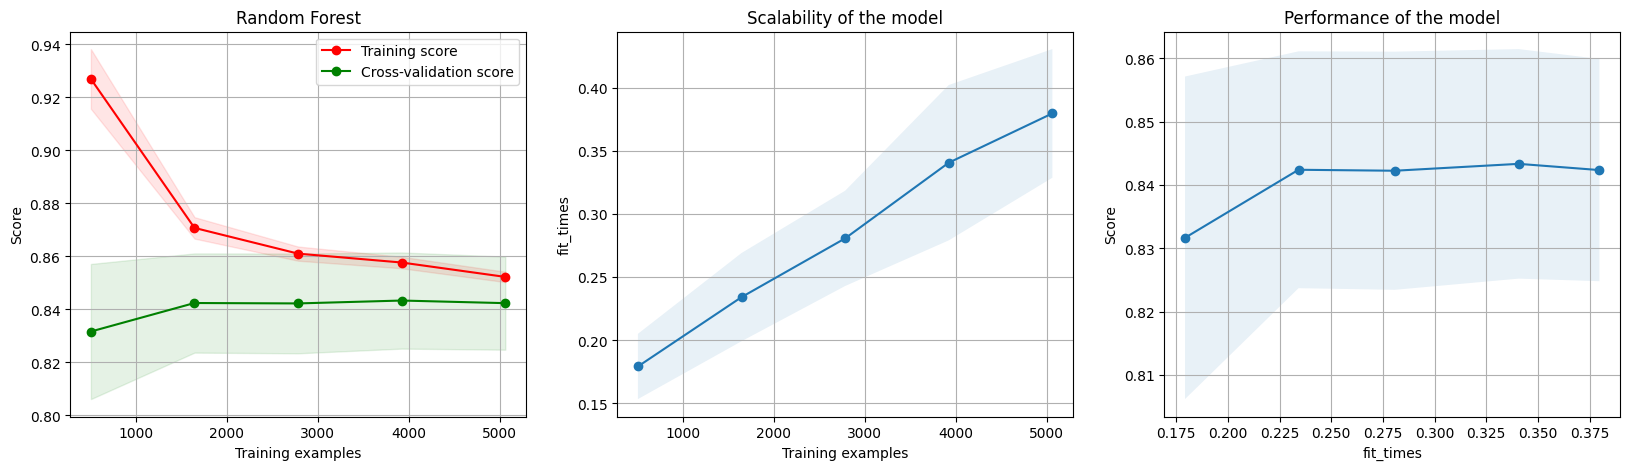

In [299]:
estimator_rf = RandomForestClassifier(max_depth = 4, max_features = 4, n_estimators = 100)
plot_learning_curve(estimator_rf, 'Random Forest', X_train_tr, y_train_tr, cv=10)
plt.show()

Con este valor de max_depth, la regularización se hace suficientemente fuerte para controlar el sobreajuste.

## Modelo final

### Regresión Logistica

In [301]:
columnas_categoricas = df_lr.select_dtypes('object').columns

encoder = WOEEncoder()
encoder.fit(X_train_lr[columnas_categoricas], y_train_lr)

X_train_lr[columnas_categoricas] = encoder.transform(X_train_lr[columnas_categoricas])
X_test_lr[columnas_categoricas] = encoder.transform(X_test_lr[columnas_categoricas])

In [302]:
columnas_continuas = ['tenure','MonthlyCharges', 'TotalCharges']

scaler = MinMaxScaler()
scaler.fit(X_train_lr[columnas_continuas], y_train_lr)

X_train_lr[columnas_continuas] = scaler.transform(X_train_lr[columnas_continuas])
X_test_lr[columnas_continuas] = scaler.transform(X_test_lr[columnas_continuas])

In [303]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=1000, class_weight=None)
model.fit(X_train_lr, y_train_lr)

LogisticRegression(C=1000, penalty='l1', solver='liblinear')

In [304]:
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(X_test_lr)[:,1]

print(f'AUC test OoT = {roc_auc_score(y_test, y_proba)}')

AUC test OoT = 0.836652499598801


Puede observarse que el AUC de la muestra de prueba es bastante similar a la medida en validación cruzada, lo cual da señales de que el modelo es estable.

### Random Forest

In [305]:
model_tr = RandomForestClassifier(max_depth = 4, max_features = 4, n_estimators = 100)
model_tr.fit(X_train_tr, y_train_tr)

RandomForestClassifier(max_depth=4, max_features=4)

In [306]:
from sklearn.metrics import roc_auc_score

y_proba_tr = model_tr.predict_proba(X_test_tr)[:,1]

print(f'AUC test OoT = {roc_auc_score(y_test_tr, y_proba_tr)}')

AUC test OoT = 0.8438080767817114


Puede observarse que el AUC de la muestra de prueba es bastante similar a la medida en validación cruzada, lo cual da señales de que el modelo es estable.

Ahora, se tienen dos potenciales modelos. Como no sería correcto usar la medición en el set de prueba para escoger entre los dos (solo es un valor para reportar, no para tomar decisión), se recurrirá a otros criterios. Uno de ellos es la interpretabilidad.

## Interpretabilidad

### Regresión Logística

#### Analisis de correlaciones
Primero, se valida si existen variables correlacionadas entre sí. De ser así, podrían eliminarse variables y reentrenar el modelo.

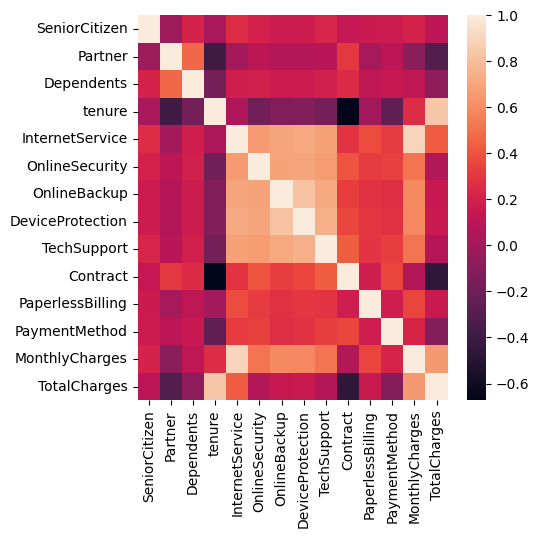

In [307]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(X_train_lr.corr())
plt.show()

No hay variables que esten fuertemente correlacionada (abd(corr) > 0.8). Luego, no se elimina ninguna.

#### Importancia de variables
Se puede medir y cuantificar la importancia de variables usando sus valores SHAP.

In [308]:
import shap

explainer_lr = shap.LinearExplainer(model, X_train_lr)
shap_values_lr = explainer_lr(X_train_lr)

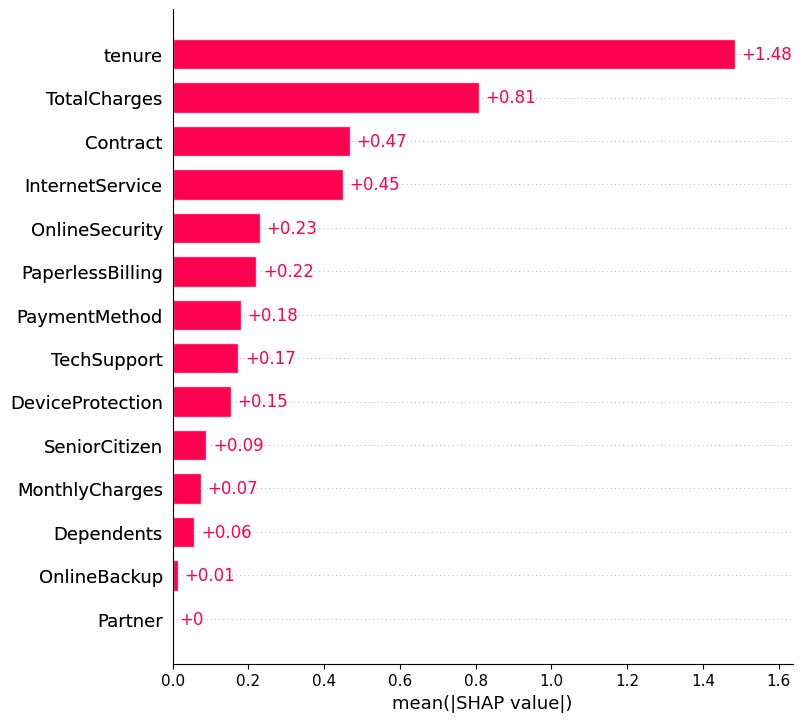

In [309]:
shap.plots.bar(shap_values_lr, max_display = 15)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


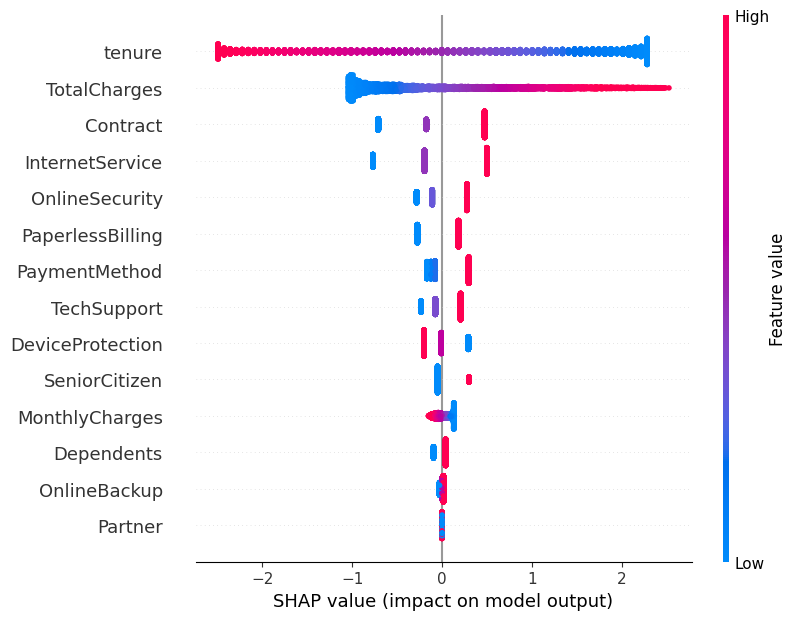

In [310]:
shap.plots.beeswarm(shap_values_lr, max_display = 15)

En este caso, puede verse el impacto de cada variable en la probabilidad de que el cliente fuge. Sin embargo, hay algunos valores que no guardan mucho sentido con lo observado en el exploratorio. Por ejemplo, a nivel de deuda total, pareciera que a mayor deuda facturada, mayor es la probabilidad de que fuge. SIn embargo, en el exploratorio se ve que los que tienen mayor factura, tienen menor ratio de fuga. Esto requiere un análisis más profundo para ver por qué se da esta casuística.

## Random Forest

### Importancia de variables

In [314]:
import shap

explainer_tr = shap.Explainer(model_tr, X_train_tr)
shap_values_tr = explainer_tr(X_train_tr)

 98%|===================| 11078/11250 [00:42<00:00]       

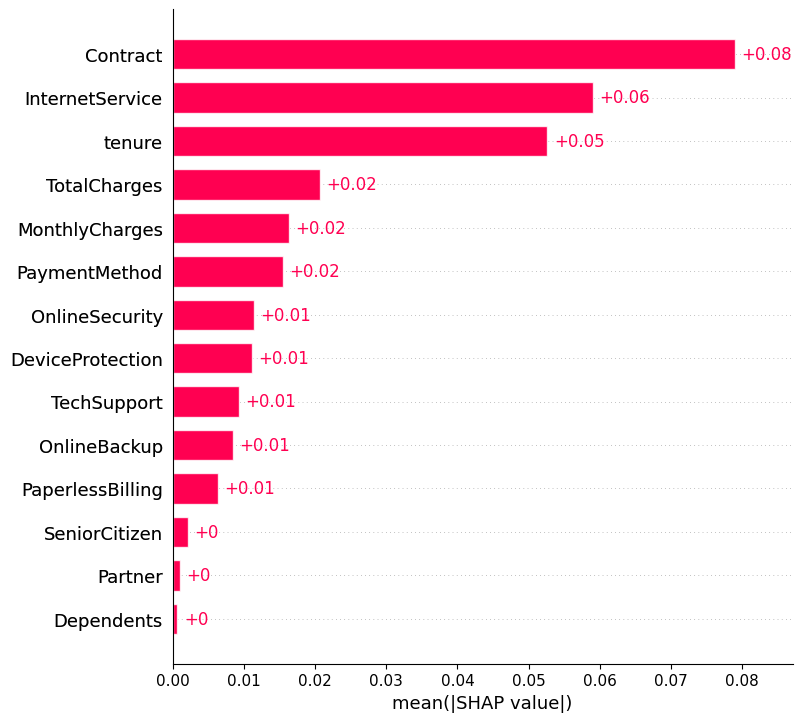

In [317]:
shap.plots.bar(shap_values_tr[:,:,1], max_display = 15)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


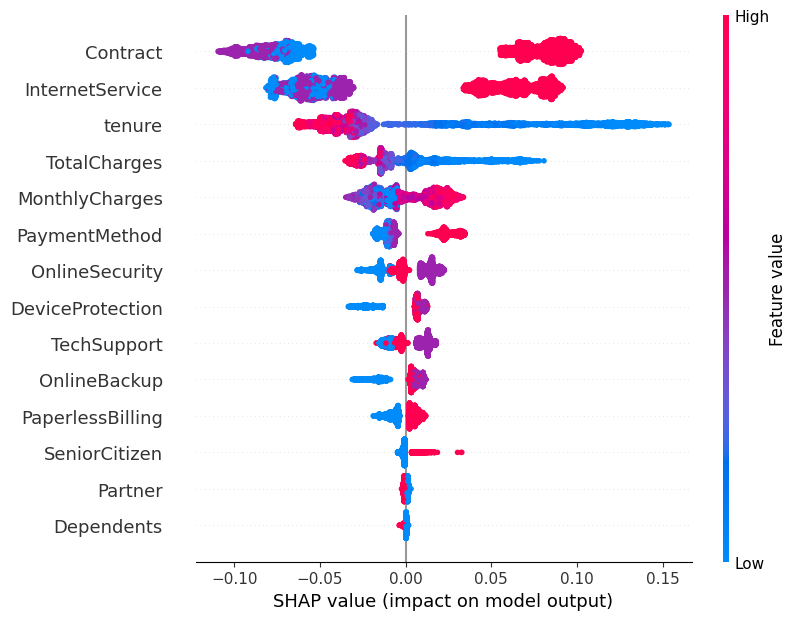

In [318]:
shap.plots.beeswarm(shap_values_tr[:,:,1], max_display = 15)

En el caso del RandomForest, si bien como algoritmo no es tan sencillo de explicar, puede verse el impacto directo de las variables, ya que entran directo al algoritmo sin tener que ser procesadas en exceso.

### Aproximacion de Random Forest por Arbol
La literatura cuenta del uso de árboles de decisión para dar mayor interpretabilidad a RandomForest.

In [337]:
import shap

model_dt = DecisionTreeClassifier(max_depth=4)
model_dt.fit(X_train_tr, y_train_tr)

explainer_dt = shap.Explainer(model_dt, X_train_tr)
shap_values_dt = explainer_dt(X_train_tr)

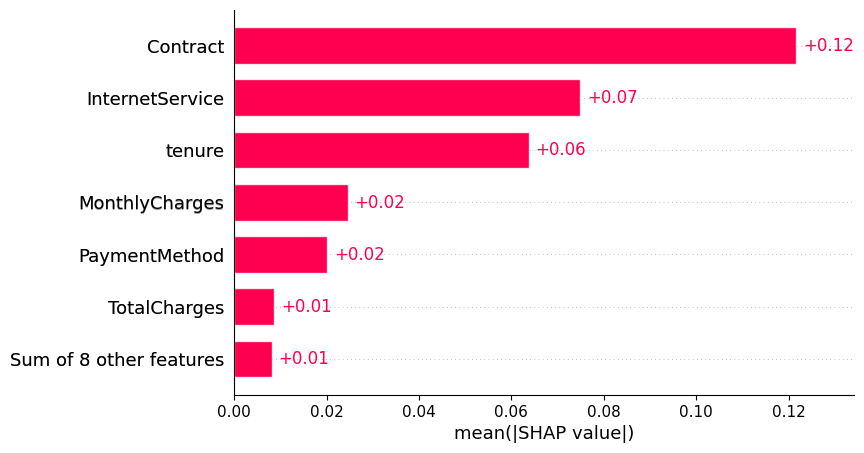

In [338]:
shap.plots.bar(shap_values_dt[:,:,1], max_display = 7)

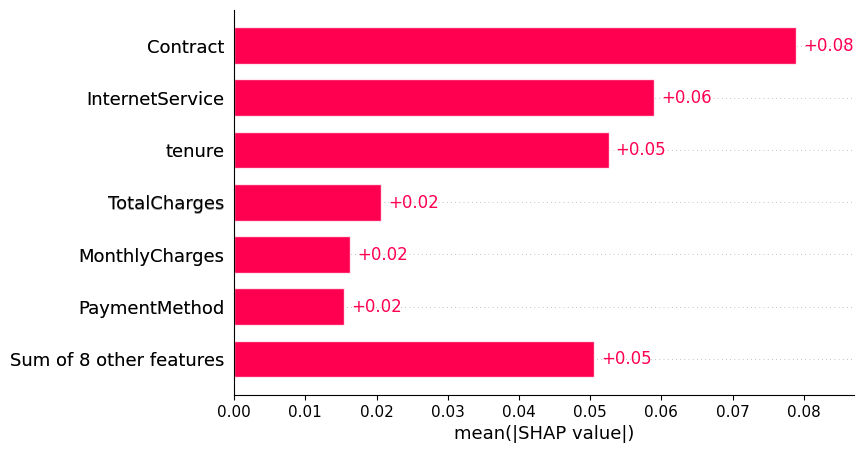

In [339]:
shap.plots.bar(shap_values_tr[:,:,1], max_display = 7)

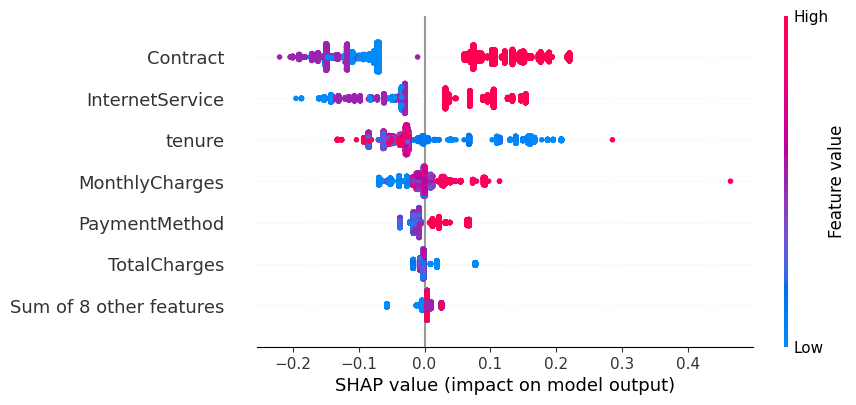

In [341]:
shap.plots.beeswarm(shap_values_dt[:,:,1], max_display = 7)

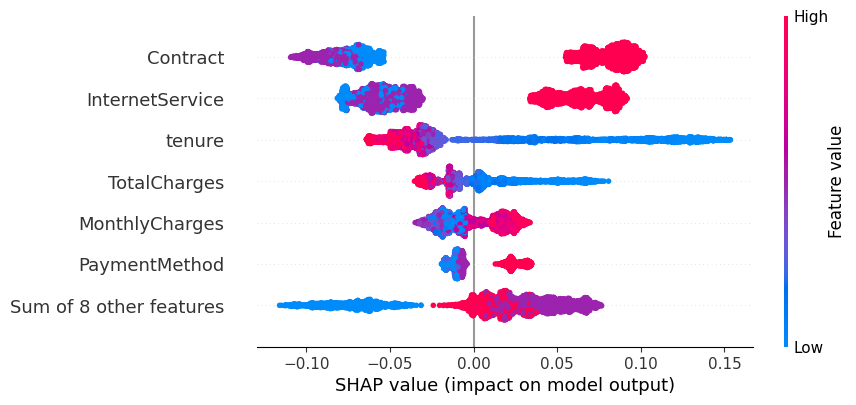

In [342]:
shap.plots.beeswarm(shap_values_tr[:,:,1], max_display = 7)

Puede observarse que el arbol de decisión es una buena aproximación al random forest para entender cómo está operando. Puede verse, por ejemplo, que el top de las 6 variables son casi iguales. Asimismo, puede apreciarse que en el random forest el comportamiento de cada variable es una versión acentuada de lo que se observa en el arbol de decisión.

Por todo lo anterior, se considera mejor implementar el Random Forest y, para mejorar su interpretabilidad, presentar las variables y su impacto. Asimismo, podría ayudarse del árbol de decisión para explicar o tener un gasp del funcionamiento del bósque.

In [345]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


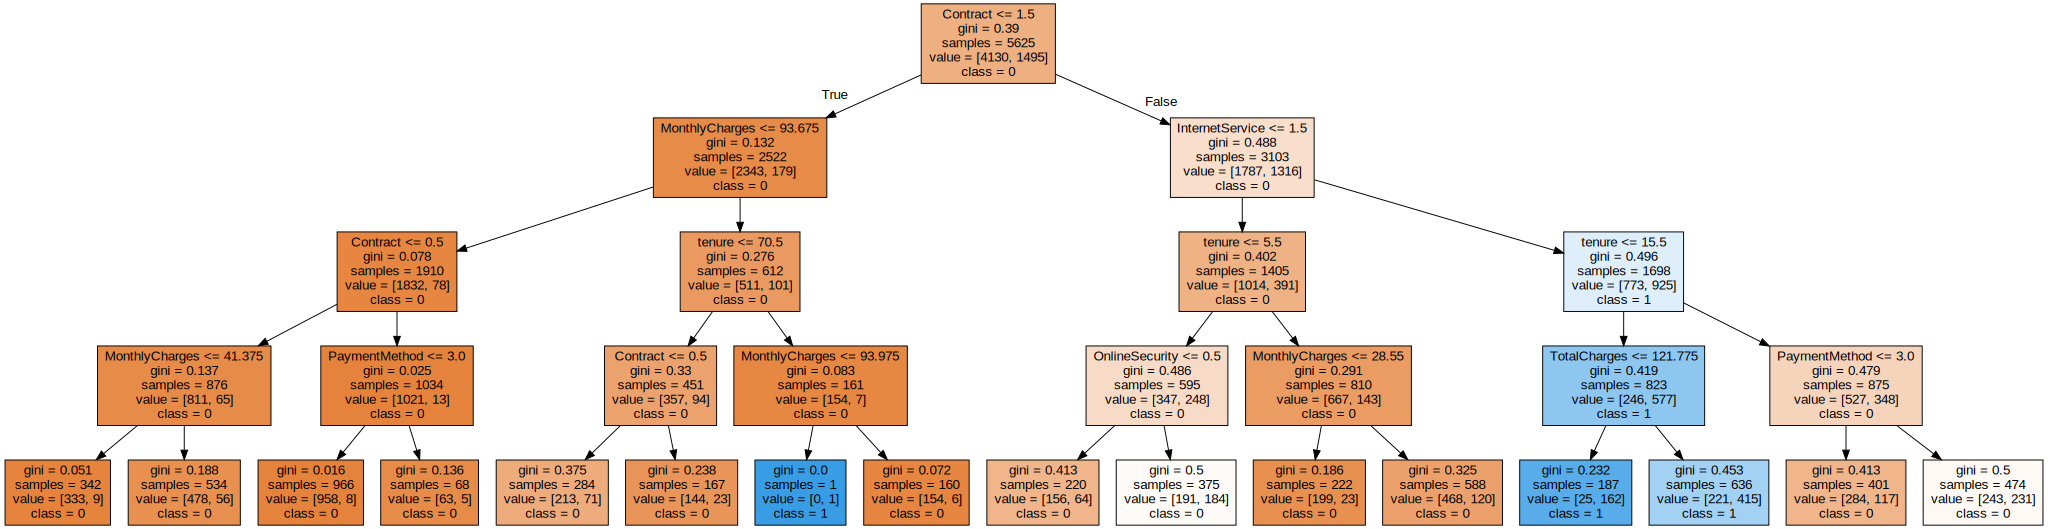

In [347]:
import graphviz
from sklearn import tree

features = X_train_tr.columns
classes = ['0','1']

dot_data = tree.export_graphviz(model_dt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)

graph = graphviz.Source(dot_data, format="png")
graph

In [348]:
graph.render("decision_tree_graphivz")

'decision_tree_graphivz.png'

### Rescatar objetos
Guardamos todos los objetos creados en el presente notebook.

In [349]:
import pickle

with open('woe_encoder.pckl','wb') as file:
    pickle.dump(encoder, file)

with open('minmax_scaler.pckl','wb') as file:
    pickle.dump(scaler, file)

with open('logistic_regression.pckl','wb') as file:
    pickle.dump(model, file)

with open('random_forest.pckl','wb') as file:
    pickle.dump(model_tr, file)

with open('decision_tree.pckl','wb') as file:
    pickle.dump(model_dt, file)

## Analisis sobre set de prueba

In [380]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)

    kstable['total'] = kstable[['events', 'nonevents']].sum(axis=1)
    kstable['event_prop'] = (kstable['events']/kstable['total']).apply('{0:.2%}'.format)

    events_total = kstable['events'].sum()
    total = kstable['total'].sum()
    events_prop_tot = events_total / total

    kstable['lift'] = ((kstable['events']/kstable['total']) / events_prop_tot).apply('{0:.2}'.format)

    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)

    return(kstable)

In [382]:
y_proba_tr = model_tr.predict_proba(X_test_tr)[:,1]
y_dict = {'y':y_test_tr, 'P':y_proba_tr}
dataframe = pd.DataFrame.from_dict(y_dict, orient='columns')
ks(data=dataframe, target='y', prob='P')

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,total,event_prop,lift,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,,
1,0.601170,0.744652,100,41,26.74%,3.97%,141,70.92%,2.7,26.74%,3.97%,22.8
2,0.467646,0.600779,81,60,21.66%,5.81%,141,57.45%,2.2,48.40%,9.78%,38.6
3,0.391551,0.466319,67,73,17.91%,7.07%,140,47.86%,1.8,66.31%,16.84%,49.5
4,0.297330,0.391000,52,89,13.90%,8.62%,141,36.88%,1.4,80.21%,25.46%,54.8
5,0.213306,0.297220,36,104,9.63%,10.07%,140,25.71%,0.97,89.84%,35.53%,54.3
6,0.156485,0.213297,17,124,4.55%,12.00%,141,12.06%,0.45,94.39%,47.53%,46.9
7,0.097153,0.156011,10,131,2.67%,12.68%,141,7.09%,0.27,97.06%,60.21%,36.8
8,0.052384,0.096446,4,136,1.07%,13.17%,140,2.86%,0.11,98.13%,73.38%,24.7
9,0.020558,0.052170,4,137,1.07%,13.26%,141,2.84%,0.11,99.20%,86.64%,12.6


Puede observarse que el algoritmo ordena correctamente la tasa de malos por decil de riesgo.

In [383]:
y_proba_lr = model.predict_proba(X_test_lr)[:,1]
y_dict = {'y':y_test, 'P':y_proba_lr}
dataframe = pd.DataFrame.from_dict(y_dict, orient='columns')
ks(data=dataframe, target='y', prob='P')

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,total,event_prop,lift,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,,
1,0.647136,0.825782,92,49,24.60%,4.74%,141,65.25%,2.5,24.60%,4.74%,19.9
2,0.532258,0.647081,89,52,23.80%,5.03%,141,63.12%,2.4,48.40%,9.78%,38.6
3,0.409390,0.531768,61,79,16.31%,7.65%,140,43.57%,1.6,64.71%,17.42%,47.3
4,0.285221,0.409064,51,90,13.64%,8.71%,141,36.17%,1.4,78.34%,26.14%,52.2
5,0.188764,0.284679,40,99,10.70%,9.58%,139,28.78%,1.1,89.04%,35.72%,53.3
6,0.118662,0.188726,19,123,5.08%,11.91%,142,13.38%,0.5,94.12%,47.63%,46.5
7,0.065397,0.118451,11,130,2.94%,12.58%,141,7.80%,0.29,97.06%,60.21%,36.8
8,0.023944,0.065154,5,135,1.34%,13.07%,140,3.57%,0.13,98.40%,73.28%,25.1
9,0.007631,0.023632,1,140,0.27%,13.55%,141,0.71%,0.027,98.66%,86.83%,11.8


## Definicion de puntos de corte
En base al conjunto de entrenamiento, se definen los puntos de corte para tener los grupos de riesgo.

In [384]:
y_proba_tr_train = model_tr.predict_proba(X_train_tr)[:,1]
y_dict = {'y':y_train_tr, 'P':y_proba_tr_train}
dataframe = pd.DataFrame.from_dict(y_dict, orient='columns')
ks(data=dataframe, target='y', prob='P')

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,total,event_prop,lift,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,,,,
1,0.599926,0.742249,432,129,28.90%,3.12%,561,77.01%,2.9,28.90%,3.12%,25.8
2,0.463602,0.599900,340,224,22.74%,5.42%,564,60.28%,2.3,51.64%,8.55%,43.1
3,0.388677,0.463306,251,312,16.79%,7.55%,563,44.58%,1.7,68.43%,16.10%,52.3
4,0.303227,0.388618,169,393,11.30%,9.52%,562,30.07%,1.1,79.73%,25.62%,54.1
5,0.213509,0.303149,120,442,8.03%,10.70%,562,21.35%,0.8,87.76%,36.32%,51.4
6,0.152887,0.213479,90,473,6.02%,11.45%,563,15.99%,0.6,93.78%,47.77%,46.0
7,0.098186,0.152734,49,513,3.28%,12.42%,562,8.72%,0.33,97.06%,60.19%,36.9
8,0.060738,0.098030,35,528,2.34%,12.78%,563,6.22%,0.23,99.40%,72.98%,26.4
9,0.027749,0.060643,6,556,0.40%,13.46%,562,1.07%,0.04,99.80%,86.44%,13.4


## Predecir sobre data nueva

In [353]:
filename = 'TelcoCustomerChurn_New.csv'

df_new = pd.read_csv(filename, sep = ';', index_col = 0)
df_new.shape

(19, 19)

In [355]:
df_new.drop(columns = ['gender', 'MultipleLines', 'PhoneService', 'StreamingTV', 'StreamingMovies'], inplace = True)

In [357]:
df_new = df_new.fillna(0)

In [358]:
# Variables binarias
df_new['Partner']          = df_new['Partner'].map({'Yes':1,'No':0})
df_new['Dependents']       = df_new['Dependents'].map({'Yes':1,'No':0})
df_new['PaperlessBilling'] = df_new['PaperlessBilling'].map({'Yes':1,'No':0})

# Variables ternarias
df_new['InternetService']  = df_new['InternetService'].map({'Fiber optic':2, 'DSL':1, 'No':0})
df_new['OnlineSecurity']   = df_new['OnlineSecurity'].map({'Yes':2, 'No':1, 'No internet service':0})
df_new['OnlineBackup']     = df_new['OnlineBackup'].map({'Yes':2, 'No':1, 'No internet service':0})
df_new['DeviceProtection'] = df_new['DeviceProtection'].map({'Yes':2, 'No':1, 'No internet service':0})
df_new['TechSupport']      = df_new['TechSupport'].map({'Yes':2, 'No':1, 'No internet service':0})
df_new['Contract']         = df_new['Contract'].map({'Month-to-month':2, 'Two year':1, 'One year':0})

# Variables cuaternarias
df_new['PaymentMethod']    = df_new['PaymentMethod'].map({'Electronic check':4, 'Mailed check':2, 'Bank transfer (automatic)':1, 'Credit card (automatic)':0})

In [360]:
import pickle

with open('random_forest.pckl','rb') as file:
    model_prod = pickle.load(file)

In [362]:
y_pred = model_prod.predict(df_new)
y_proba = model_prod.predict_proba(df_new)[:,1]

In [363]:
df_new['prediccion'] = y_pred
df_new['probabilidad'] = y_proba

In [386]:
df_new['decil'] = pd.cut(df_new['probabilidad'], bins = [-0.1,0.027665, 0.060643, 0.098030, 0.152734, 0.213479, 0.303149, 0.388618, 0.463306, 0.599900, 1.01], labels = [f'D{x}' for x in range(10,0,-1)])

In [390]:
df_new.groupby('decil')['probabilidad'].describe()

,count,mean,std,min,25%,50%,75%,max
decil,,,,,,,,
D10,1.0,0.014833,NaN,0.014833,0.014833,0.014833,0.014833,0.014833
D9,2.0,0.050843,0.002529,0.049056,0.049950,0.050843,0.051737,0.052631
D8,2.0,0.071065,0.009091,0.064636,0.067851,0.071065,0.074279,0.077493
D7,1.0,0.145501,NaN,0.145501,0.145501,0.145501,0.145501,0.145501
D6,2.0,0.192124,0.000651,0.191663,0.191893,0.192124,0.192354,0.192584
D5,2.0,0.220251,0.008358,0.214342,0.217296,0.220251,0.223206,0.226161
D4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D3,4.0,0.447977,0.012826,0.431187,0.444153,0.449164,0.452989,0.462394
D2,5.0,0.517570,0.047915,0.469778,0.482067,0.498419,0.565287,0.572297


In [391]:
df_new.head()

,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,prediccion,probabilidad,decil
customerID,,,,,,,,,,,,,,,,,
CC001_New,0,1,1,53,0,0,0,0,0,1,1,2,19.40,1110.35,0,0.014833,D10
CC002_New,0,0,0,27,1,1,1,2,2,2,0,4,59.45,1611.65,0,0.214342,D5
CC003_New,1,0,0,23,2,1,2,1,1,2,1,4,94.75,2293.60,0,0.482067,D2
CC004_New,0,0,0,69,1,2,2,2,2,1,1,0,81.50,5553.25,0,0.049056,D9
CC005_New,0,1,1,2,1,1,1,1,2,2,0,1,29.05,44.75,0,0.431187,D3


In [392]:
df_new.reset_index().to_csv('TelcoCustomerChurn_New_Scored.csv', sep=';', index=False)